In [1]:
from anchor import utils
from anchor import anchor_tabular
import pandas as pd
import sklearn.ensemble


In [2]:
dataset_folder = '../datasets/'
dataset = utils.load_dataset('adult', balance=True, dataset_folder=dataset_folder, discretize=True)

In [3]:
c = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)
c.fit(dataset.train, dataset.labels_train)
print('Train', sklearn.metrics.accuracy_score(dataset.labels_train, c.predict(dataset.train)))
print('Test', sklearn.metrics.accuracy_score(dataset.labels_test, c.predict(dataset.test)))

Train 0.9350338780390594
Test 0.8489483747609943


In [21]:
transformed_data = []

for r in dataset.train:
    transformed_data.append([dataset.categorical_names[i][int(r_)] for i, r_ in enumerate(r)])        

print(transformed_data[0])

train_data = pd.DataFrame(transformed_data, columns=dataset.feature_names)
print(train_data.shape)
nb_vals = 25

y=[]
for k in range(0, nb_vals):
    y.append(c.predict(dataset.train[k].reshape(1, -1))[0])


['Age > 48.00', 'Self-emp-not-inc', 'Some-college', 'Married-civ-spouse', 'Sales', 'Husband', 'White', 'Male', '2', '0', '40.00 < Hours per week <= 45.00', 'United-States']
(12545, 12)


In [59]:
import arg_explainer as ae
from importlib import reload
reload(ae)
import arg_explainer as ae
explainer = ae.ArgTabularExplainer(c, train_data.iloc[0:nb_vals], y, 'adult_25', compute=True)

300  potential arg checked.
len  1 : 16 ,  15
1650  potential arg checked.
len  2 : 43 ,  66
5500  potential arg checked.
len  3 : 18 ,  9
12375  potential arg checked.
len  4 : 15 ,  0
19800  potential arg checked.
len  5 : 0 ,  0
Saving to  saves\adult_25_minimals.df


adult_25
len 1489
[(frozenset({57}), 32) (frozenset({9}), 32) (frozenset({39}), 33)
 (frozenset({46}), 33) (frozenset({47}), 33)
 (frozenset({32, 35, 51, 7}), 71) (frozenset({32, 51, 44, 45}), 71)
 (frozenset({32, 35, 51, 45}), 71) (frozenset({32, 51, 44, 7}), 71)
 (frozenset({32, 35, 42, 51}), 71) (frozenset({32, 35, 58, 51}), 71)
 (frozenset({32, 42, 51, 44}), 73) (frozenset({16, 35, 42, 51}), 73)
 (frozenset({58, 51, 6, 14}), 74) (frozenset({16, 42, 51, 44}), 75)
 (frozenset({16, 42, 51, 7}), 75) (frozenset({32, 58, 51, 44}), 75)
 (frozenset({48, 51, 45, 6}), 76) (frozenset({51, 45, 6, 14}), 77)
 (frozenset({48, 58, 51, 6}), 80)]
182  args in total.


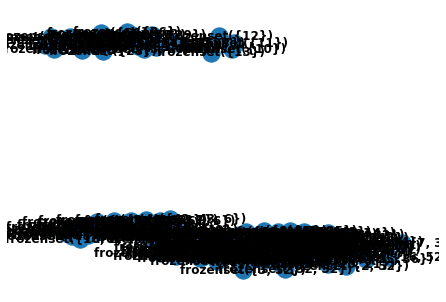

In [60]:
explainer.build_attack_graph()
explainer.build_naive_extensions()

In [61]:
explainer.strategy('max_covi')
## Define strategy before calling explainer.explain()
explainer.display_explanations()

25 / 300
0 {frozenset({'Education_Some-college', 'Workclass_Self-emp-not-inc'}), frozenset({'Workclass_Self-emp-not-inc', 'Occupation_Sales'}), frozenset({'Education_Some-college', 'Relationship_Husband'}), frozenset({'Education_Some-college', 'Age_Age > 48.00', 'Sex_Male'}), frozenset({'Age_Age > 48.00', 'Workclass_Self-emp-not-inc'}), frozenset({'Education_Some-college', 'Marital Status_Married-civ-spouse'}), frozenset({'Education_Some-college', 'Occupation_Sales'}), frozenset({'Age_Age > 48.00', 'Occupation_Sales'})}
1 {frozenset({'Age_37.00 < Age <= 48.00', 'Marital Status_Never-married'}), frozenset({'Occupation_Exec-managerial', 'Age_37.00 < Age <= 48.00'}), frozenset({'Relationship_Not-in-family', 'Marital Status_Never-married'}), frozenset({'Education_Doctorate'}), frozenset({'Occupation_Exec-managerial', 'Relationship_Not-in-family'}), frozenset({'Sex_Female', 'Race_White', 'Marital Status_Never-married'}), frozenset({'Occupation_Exec-managerial', 'Marital Status_Never-married